In [702]:
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from rfpimp import *
sns.set(style="whitegrid")
%matplotlib inline

In [703]:
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [704]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [705]:
%R library(ggplot2)

array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U9')

In [706]:
df = pd.read_csv("./winemag-data-130k-v2.csv", index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


In [707]:
df.nunique()

country                      43
description              119955
designation               37979
points                       21
price                       390
province                    425
region_1                   1229
region_2                     17
taster_name                  19
taster_twitter_handle        15
title                    118840
variety                     707
winery                    16757
dtype: int64

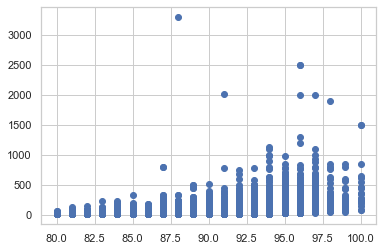

In [708]:
plt.scatter(df.points, df.price)

In [709]:
dfc = df.copy()

Using regex and some other methods I extracted what I assume to be the vintage year (some might list both bottling year and vintage)
There are a few thousand missing values or values which are outside of the reasonable range ie probably some branding or refer to when the winery was founded.

In [710]:
import re
regex = re.compile('[^0-9]')

In [711]:
title_words = [t.split(' ') for t in dfc.title]  
rem_char_titles = []
for t in title_words:
    no_char_t = []
    for w in t:
        cw = regex.sub('',w)
        if len(cw) == 4:
            no_char_t.append(cw)
    rem_char_titles.append(no_char_t)

In [712]:
vintages = []
for i,l in enumerate(rem_char_titles):
    if not l:
        vintages.append(np.nan)
    elif len(l) == 1:
        vintages.append(int(l[0]))
    else:
        l = map(int,l)
        for i in l:
            if i > 1980 and i <= current_year:
                vintages.append(i)
                break
vintages = pd.Series(vintages)      

In [713]:
# from collections import Counter
# words = []
# for desc in descriptions:
#     clean = regex.sub('',desc)
#     wl = clean.split(' ')
#     words += wl
# c = Counter(words)

Here I listed out potential interesting adjectives I found from filtering through the data, then I created columns based on their presence

In [714]:
adjectives =  ['fruit', 'strong', 'tangy', 'bitter', 'alcohol', 'floral', 'acidity', 'tobacco','tannin', 'ripe', 'spice', 'oak', 'rich', 'dry', 'crisp', 'sweet', 'vanilla', 'full', 'tropical', 'strong', 'bitter']

In [715]:
for adj in adjectives:
    dfc[adj] = 0
    dfc.loc[dfc.description.str.contains(adj),adj] = 1

In [716]:
onehot_tasters = pd.get_dummies(dfc["taster_name"])
onehot_countries = pd.get_dummies(dfc["country"])

In [717]:
onehot_region2 = pd.get_dummies(dfc["region_2"])

In [718]:
X = pd.concat([onehot_tasters, onehot_countries, onehot_region2, dfc.rich, dfc.full, dfc.dry, dfc.crisp, dfc.bitter, dfc.sweet,dfc.spice, dfc.oak, dfc.acidity, dfc.tobacco], axis=1)
y = df["points"]

In [719]:
X

,Alexander Peartree,Anna Lee C. Iijima,Anne Krebiehl MW,Carrie Dykes,Christina Pickard,Fiona Adams,Jeff Jenssen,Jim Gordon,Joe Czerwinski,Kerin O’Keefe,...,rich,full,dry,crisp,bitter,sweet,spice,oak,acidity,tobacco
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
129967,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
129968,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,1,0,0,0
129969,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,1,0,1,0


In [319]:
from rfpimp import *

In [320]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)

In [321]:
rf.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

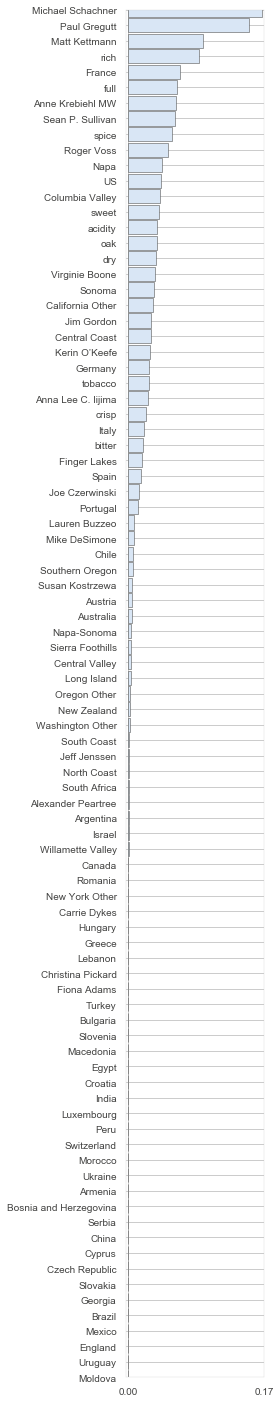

In [322]:
imp = importances(rf, X, y) # permutation
viz = plot_importances(imp)
viz.view()

In [182]:
rf.score(X, y)

0.21138841265605868

In [183]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf.fit(X_train, y_train)
medae_value = metrics.median_absolute_error(y_test, rf.predict(X_test))
medae_value

1.879068178290126

In [184]:
rf.score(X_train, y_train)

0.21167999639130963

In [18]:
# chosed 22 top predictors from rfpimp

In [720]:
dfc['france'] = 0
dfc.loc[dfc.country=='France', 'france'] = 1

In [721]:
dfc['portugal'] = 0
dfc.loc[dfc.country=='Portugal', 'portugal'] = 1

In [722]:
dfc['us'] = 0
dfc.loc[dfc.country=='US', 'us'] = 1

In [723]:
dfc['austria'] = 0
dfc.loc[dfc.country=='Austria', 'austria'] = 1

In [724]:
dfc['germany'] = 0
dfc.loc[dfc.country=='Germany', 'germany'] = 1

In [725]:
dfc['spain'] = 0
dfc.loc[dfc.country=='Spain', 'spain'] = 1

In [726]:
dfc['michael_schachner'] = 0
dfc.loc[dfc.taster_name=='Michael Schachner', 'michael_schachner'] = 1

In [727]:
dfc['roger_voss'] = 0
dfc.loc[dfc.taster_name=='Roger Voss', 'roger_voss'] = 1

In [728]:
dfc['paul_gregutt'] = 0
dfc.loc[dfc.taster_name=='Paul Gregutt', 'paul_gregutt'] = 1

In [729]:
dfc['sean_sullivan'] = 0
dfc.loc[dfc.taster_name=='Sean P. Sullivan', 'sean_sullivan'] = 1

In [730]:
dfc['anne_krebiehl'] = 0
dfc.loc[dfc.taster_name=='Anne Krebiehl MW', 'anne_krebiehl'] = 1

In [731]:
dfc['matt_kettmann'] = 0
dfc.loc[dfc.taster_name=='Matt Kettmann', 'matt_kettmann'] = 1

In [732]:
dfc['anna_lee'] = 0
dfc.loc[dfc.taster_name=='Anna Lee C. lijima', 'matt_kettmann'] = 1

In [733]:
dfc['jim_gordon'] = 0
dfc.loc[dfc.taster_name=='Jim Gordon', 'jim_gordon'] = 1

In [734]:
dfc['virginie_boone'] = 0
dfc.loc[dfc.taster_name=='Virginie Boone', 'virginie_boone'] = 1

In [735]:
dfc['columbia_valley'] = 0
dfc.loc[dfc.region_2=='Columbia Valley', 'columbia_valley'] = 1

In [736]:
dfc['cal_other'] = 0
dfc.loc[dfc.region_2=='California Other', 'cal_other'] = 1

In [737]:
dfc['sonoma'] = 0
dfc.loc[dfc.region_2=='Sonoma', 'sonoma'] = 1

In [738]:
dfc['napa'] = 0
dfc.loc[dfc.region_2=='Napa', 'napa'] = 1

In [739]:
dfc['central_coast'] = 0
dfc.loc[dfc.region_2=='Central Coast', 'central_coast'] = 1

In [740]:
dfc1 = dfc[['rich', 'full', 'dry', 'crisp', 'bitter', 'sweet', 'spice', 'oak', 'acidity', 'tobacco', 'france', 'portugal', 'us', 'spain', 'germany', 'austria', 'michael_schachner', \
           'roger_voss', 'anne_krebiehl', 'matt_kettmann', 'virginie_boone', 'paul_gregutt', 'sean_sullivan', 'anna_lee', 'jim_gordon', 'columbia_valley', 'cal_other', 'sonoma', 'napa', 'central_coast']]

In [741]:
dfc.columns

Index(['country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title',
       'variety', 'winery', 'fruit', 'strong', 'tangy', 'bitter', 'alcohol',
       'floral', 'acidity', 'tobacco', 'tannin', 'ripe', 'spice', 'oak',
       'rich', 'dry', 'crisp', 'sweet', 'vanilla', 'full', 'tropical',
       'france', 'portugal', 'us', 'austria', 'germany', 'spain',
       'michael_schachner', 'roger_voss', 'paul_gregutt', 'sean_sullivan',
       'anne_krebiehl', 'matt_kettmann', 'anna_lee', 'jim_gordon',
       'virginie_boone', 'columbia_valley', 'cal_other', 'sonoma', 'napa',
       'central_coast'],
      dtype='object')

In [742]:
price = dfc.price.fillna(df.price.median()).reset_index()
vintage = ages.fillna(vintages.median()).reset_index()

prices = np.array(df["price"].fillna(df["price"].median())).reshape(-1,1)

z_scaler = StandardScaler()
prices_scaled = z_scaler.fit_transform(prices)
prices_scaled = pd.Series(prices_scaled.flatten())
prices_scaled

In [743]:
price = price.drop('index', axis=1)
price

,price
0,25.0
1,15.0
2,14.0
3,13.0
4,65.0
...,...
129966,28.0
129967,75.0
129968,30.0
129969,32.0


In [744]:
len(dfc1.columns)

30

In [749]:
X32 = pd.concat([dfc1, price, vintage], axis=1)

In [750]:
len(X32), len(y)

(129971, 129971)

In [751]:
rf.fit(X32, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [752]:
rf.score(X32, y)

0.928657672236926

In [753]:
X_train, X_test, y_train, y_test = train_test_split(X32, y, test_size=0.2, random_state=42)
rf.fit(X_train, y_train)
print(rf.score(X_train, y_train))
print(rf.score(X_test,y_test))
medae_value = metrics.median_absolute_error(y_test, rf.predict(X_test))
print(medae_value)

0.9272913762701759
0.4907410995852981
1.3700000000000045


In [218]:
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

In [217]:
dmatrix = xgb.DMatrix(data=X22, label=y)

NameError: name 'xgb' is not defined

In [124]:
xg_reg = xgb.XGBRegressor(objective='reg:linear', colsample_bytree =0.3, learning_rate=0.5, max_depth=10, alpha=1, n_estimators=10)

In [125]:
xg_reg.fit(X_train, y_train)

/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:11:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.5, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=10,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
#randomized search cv

In [138]:
hyperparameters = {"learning_rate"    : np.arange(0.01, 2.0, 0.01) ,
                   "max_depth"        : [ 3, 4, 5, 6, 8, 9, 10, 11, 12, 15],
                   "min_child_weight" : [ 1, 3, 5, 7 ],
                   "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
                   "alpha"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
                   "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
                   "n_estimators" : [ 1, 3, 5, 7, 10, 15, 20 ]}

In [139]:
from sklearn.model_selection import RandomizedSearchCV

reg_rand = RandomizedSearchCV(xgb.XGBRegressor(), 
                              hyperparameters, 
                              cv=10, 
                              n_iter=13, 
                              verbose=1)
reg_rand.fit(X_train, y_train);

Fitting 5 folds for each of 13 candidates, totalling 65 fits
[19:26:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:26:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:   34.8s finished
/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:26:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [140]:
print(f"The test set accuracy - {reg_rand.score(X_test, y_test):.2%}")

The test set accuracy - 40.36%


In [141]:
reg_rand.best_estimator_.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.4,
 'gamma': 0.0,
 'importance_type': 'gain',
 'learning_rate': 0.9600000000000001,
 'max_delta_step': 0,
 'max_depth': 4,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 15,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1,
 'alpha': 0.3}

In [142]:
xg_reg = xgb.XGBRegressor(objective='reg:linear', colsample_bytree =0.4, learning_rate=0.96, max_depth=4, alpha=0.3,  n_estimators=15)

In [143]:
xg_reg.fit(X_train, y_train)

/Users/stephj/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:28:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=0.3, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0,
             importance_type='gain', learning_rate=0.96, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=15,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [144]:
preds = xg_reg.predict(X_test)

In [145]:
rmse = np.sqrt(mean_squared_error(y_test, preds))

In [146]:
rmse

2.364717215564562

In [147]:
medae_value = metrics.median_absolute_error(y_test, preds)
medae_value

1.5754928588867188

In [ ]:
dfc.groupby('country').agg({'points': ['mean', 'median'], 'price':['mean', 'median']})

In [50]:
reg = smf.ols('price~points+C(country)', data=df).fit()#+C(taster_name)+C(variety)+C(winery)+C(province)
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     641.1
Date:                Tue, 03 Dec 2019   Prob (F-statistic):               0.00
Time:                        18:37:17   Log-Likelihood:            -6.0854e+05
No. Observations:              120916   AIC:                         1.217e+06
Df Residuals:                  120873   BIC:                         1.218e+06
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                             -460.0389      3.179   -144.718      0.000    -466.269    -453.808
C(country)[T.Armenia]                  -14.4229     26.249     -0.549      0.583     -65.871      37.025
C(country)[T.Australia]                  0.3932      0.986      0.399      0.690      -1.539       2.325
C(country)[T.Austria]                  -13.1966      0.935    -14.112      0.000     -15.029     -11.364
C(country)[T.Bosnia and Herzegovina]   -10.8348     26.249     -0.413      0.680     -62.283      40.614
C(country)[T.Brazil]                    10.7157      5.448      1.967      0.049       0.038      21.393
C(country)[T.Bulgaria]                 -16.7149      3.184     -5.250      0.000     -22.955     -10.475
C(country)[T.Canada]                    -3.7046      2.408     -1.538      0.124      -8.424       1.015
C(country)[T.Chile]                     -2.5230      0.824     -3.063      0.002      -4.138      -0.908
C(country)[T.China]                    -19.3051     37.117     -0.520      0.603     -92.054      53.444
C(country)[T.Croatia]                   -2.6458      4.446     -0.595      0.552     -11.360       6.068
C(country)[T.Cyprus]                   -10.8721     11.206     -0.970      0.332     -32.836      11.092
C(country)[T.Czech Republic]            -3.2759     10.731     -0.305      0.760     -24.307      17.756
C(country)[T.Egypt]                  -4.692e-13   1.05e-12     -0.447      0.655   -2.53e-12    1.59e-12
C(country)[T.England]                    0.1223      4.512      0.027      0.978      -8.721       8.966
C(country)[T.France]                     5.3156      0.670      7.929      0.000       4.002       6.630
C(country)[T.Georgia]                  -10.5994      4.094     -2.589      0.010     -18.624      -2.574
C(country)[T.Germany]                    0.2790      1.014      0.275      0.783      -1.709       2.267
C(country)[T.Greece]                    -5.3766      1.832     -2.935      0.003      -8.967      -1.787
C(country)[T.Hungary]                    2.4182      3.142      0.770      0.442      -3.740       8.577
C(country)[T.India]                    -30.8017     12.386     -2.487      0.013     -55.079      -6.525
C(country)[T.Israel]                    -2.7250      1.785     -1.526      0.127      -6.224       0.774
C(country)[T.Italy]                      4.4923      0.673      6.676      0.000       3.173       5.811
C(country)[T.Lebanon]                    0.7250      6.302      0.115      0.908     -11.628      13.078
C(country)[T.Luxembourg]               -12.1091     15.163     -0.799      0.425     -41.829      17.611
C(country)[T.Macedonia]                 -9.6141     10.730     -0.896      0.370     -30.646      11.417
C(country)[T.Mexico]                  

In [51]:
reg = smf.ols('price~points+C(taster_name)', data=df).fit()#+C(taster_name)+C(variety)+C(winery)+C(province)
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     1108.
Date:                Tue, 03 Dec 2019   Prob (F-statistic):               0.00
Time:                        18:37:18   Log-Likelihood:            -4.9038e+05
No. Observations:               96479   AIC:                         9.808e+05
Df Residuals:                   96459   BIC:                         9.810e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                             -490.2899      4.309   -113.782      0.000    -498.736    -481.844
C(taster_name)[T.Anna Lee C. Iijima]   -14.6908      2.012     -7.303      0.000     -18.634     -10.748
C(taster_name)[T.Anne Krebiehl MW]     -26.6029      2.044    -13.014      0.000     -30.610     -22.596
C(taster_name)[T.Carrie Dykes]          -1.5017      3.836     -0.391      0.695      -9.020       6.017
C(taster_name)[T.Christina Pickard]    -11.6887     16.043     -0.729      0.466     -43.132      19.754
C(taster_name)[T.Fiona Adams]           -4.1609      7.750     -0.537      0.591     -19.350      11.029
C(taster_name)[T.Jeff Jenssen]         -21.7303      2.607     -8.335      0.000     -26.840     -16.620
C(taster_name)[T.Jim Gordon]           -18.8814      2.016     -9.364      0.000     -22.833     -14.929
C(taster_name)[T.Joe Czerwinski]       -10.1182      2.001     -5.057      0.000     -14.040      -6.197
C(taster_name)[T.Kerin O’Keefe]         -5.5740      1.964     -2.838      0.005      -9.424      -1.724
C(taster_name)[T.Lauren Buzzeo]        -14.9032      2.140     -6.964      0.000     -19.098     -10.709
C(taster_name)[T.Matt Kettmann]        -15.6919      1.991     -7.881      0.000     -19.594     -11.789
C(taster_name)[T.Michael Schachner]    -10.2010      1.947     -5.240      0.000     -14.016      -6.386
C(taster_name)[T.Mike DeSimone]        -20.5148      2.594     -7.910      0.000     -25.598     -15.431
C(taster_name)[T.Paul Gregutt]         -14.9631      1.966     -7.609      0.000     -18.817     -11.109
C(taster_name)[T.Roger Voss]            -7.0469      1.943     -3.626      0.000     -10.856      -3.238
C(taster_name)[T.Sean P. Sullivan]     -12.5220      2.003     -6.252      0.000     -16.448      -8.597
C(taster_name)[T.Susan Kostrzewa]      -10.7780      2.259     -4.770      0.000     -15.206      -6.350
C(taster_name)[T.Virginie Boone]        -2.7700      1.967     -1.408      0.159      -6.625       1.085
points                                   6.0491      0.045    134.623      0.000       5.961       6.137
==============================================================================
Omnibus:                   225635.075   Durbin-Watson:                   1.655
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       5631982055.648
Skew:                          22.909   Prob(JB):                         0.00
Kurtosis:                    1185.754   Cond. No.                     1.14e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+04. This might indicate that there are
strong mult

In [52]:
# Variety doesn't seem like an important predictor based on p-values
reg = smf.ols('price~points+C(variety)', data=df).fit()#C(country)+C(taster_name)+C(variety)+C(winery)+C(province)
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     48.75
Date:                Tue, 03 Dec 2019   Prob (F-statistic):               0.00
Time:                        18:37:27   Log-Likelihood:            -6.0592e+05
No. Observations:              120974   AIC:                         1.213e+06
Df Residuals:                  120276   BIC:                         1.220e+06
Df Model:                         697                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                          -423.5354     21.212    -19.967      0.000    -465.110    -381.961
C(variety)[T.Agiorgitiko]                            -8.1077     21.468     -0.378      0.706     -50.184      33.969
C(variety)[T.Aglianico]                              -5.1677     21.081     -0.245      0.806     -46.486      36.151
C(variety)[T.Aidani]                                 21.6392     41.949      0.516      0.606     -60.580     103.858
C(variety)[T.Airen]                                   5.3826     29.663      0.181      0.856     -52.756      63.521
C(variety)[T.Albana]                                -19.8767     22.569     -0.881      0.378     -64.112      24.359
C(variety)[T.Albanello]                              -6.2826     41.948     -0.150      0.881     -88.500      75.935
C(variety)[T.Albariño]                              -14.0115     21.040     -0.666      0.505     -55.250      27.227
C(variety)[T.Albarossa]                               3.2565     33.163      0.098      0.922     -61.742      68.255
C(variety)[T.Aleatico]                               14.7750     27.746      0.533      0.594     -39.607      69.157
C(variety)[T.Alfrocheiro]                           -13.7769     22.856     -0.603      0.547     -58.574      31.021
C(variety)[T.Alicante]                              -10.6052     26.530     -0.400      0.689     -62.604      41.394
C(variety)[T.Alicante Bouschet]                     -13.0795     21.620     -0.605      0.545     -55.454      29.295
C(variety)[T.Aligoté]                                -9.3328     22.032     -0.424      0.672     -52.516      33.850
C(variety)[T.Alsace white blend]                    -19.4476     21.607     -0.900      0.368     -61.797      22.901
C(variety)[T.Altesse]                               -22.7913     24.594     -0.927      0.354     -70.996      25.413
C(variety)[T.Alvarelhão]                             -7.8978     33.163     -0.238      0.812     -72.897      57.101
C(variety)[T.Alvarinho]                             -20.1491     21.244     -0.948      0.343     -61.786      21.488
C(variety)[T.Alvarinho-Chardonnay]                  -18.9554     27.746     -0.683      0.494     -73.337      35.427
C(variety)[T.Ansonica]                               -2.8978     33.163     -0.087      0.930     -67.897      62.101
C(variety)[T.Antão Vaz]                             -15.4404     22.750     -0.679      0.497     -60.029      29.148
C(variety)[T.Apple]                                 -12.9739     33.163     -0.391      0.696     -77.973      52.025
C(variety)[T.Aragonez]                              -13.2435     25.688     -0.516      0.606     -63.591      37.104
C(variety)[T.Ar

In [53]:
# Province doesn't seem important either
reg = smf.ols('price~points+C(province)', data=df).fit()#+C(taster_name)+C(variety)+C(winery)+C(province)
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     81.88
Date:                Tue, 03 Dec 2019   Prob (F-statistic):               0.00
Time:                        18:37:31   Log-Likelihood:            -6.0545e+05
No. Observations:              120916   AIC:                         1.212e+06
Df Residuals:                  120493   BIC:                         1.216e+06
Df Model:                         422                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                       -435.1419     16.502    -26.368      0.000    -467.486    -402.798
C(province)[T.Aconcagua Costa]                    -9.6955     17.641     -0.550      0.583     -44.272      24.881
C(province)[T.Aconcagua Valley]                    4.5206     16.556      0.273      0.785     -27.930      36.971
C(province)[T.Aegean]                             -6.4351     17.952     -0.358      0.720     -41.621      28.751
C(province)[T.Agioritikos]                        -1.8478     26.462     -0.070      0.944     -53.713      50.017
C(province)[T.Ahr]                                12.4980     20.211      0.618      0.536     -27.116      52.112
C(province)[T.Alenquer]                          -22.0774     21.941     -1.006      0.314     -65.082      20.927
C(province)[T.Alentejano]                        -13.2161     16.254     -0.813      0.416     -45.074      18.641
C(province)[T.Alentejo]                          -11.5327     16.447     -0.701      0.483     -43.769      20.703
C(province)[T.Alenteo]                           -16.7472     39.693     -0.422      0.673     -94.545      61.050
C(province)[T.Algarve]                           -10.8143     20.211     -0.535      0.593     -50.427      28.798
C(province)[T.Alsace]                            -12.9308     16.224     -0.797      0.425     -44.729      18.868
C(province)[T.America]                            -6.8711     16.626     -0.413      0.679     -39.457      25.715
C(province)[T.Amindeo]                            16.7812     30.316      0.554      0.580     -42.638      76.200
C(province)[T.Amyndeon]                            3.9283     22.917      0.171      0.864     -40.988      48.845
C(province)[T.Andalucia]                          -8.4886     16.419     -0.517      0.605     -40.670      23.693
C(province)[T.Ankara]                            -14.3458     18.318     -0.783      0.434     -50.248      21.557
C(province)[T.Apalta]                              4.5578     19.287      0.236      0.813     -33.245      42.361
C(province)[T.Arcadia]                            10.5924     39.693      0.267      0.790     -67.205      88.390
C(province)[T.Arizona]                            11.1392     17.188      0.648      0.517     -22.548      44.826
C(province)[T.Armenia]                           -17.5774     30.316     -0.580      0.562     -76.996      41.841
C(province)[T.Atalanti Valley]                    -9.0545     18.878     -0.480      0.631     -46.055      27.946
C(province)[T.Atlantida]                          -4.2038     22.917     -0.183      0.854     -49.120      40.713
C(province)[T.Attica]                             -3.3447     21.941     -0.152      0.879   

# Don't run this-- takes forever
reg = smf.ols('price~points+C(winery)', data=df).fit()#+C(taster_name)+C(variety)+C(winery)+C(province)
reg.summary()

v country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
D points                   129971 non-null int64
v price                    120975 non-null float64
- province                 129908 non-null object
- region_1                 108724 non-null object
v region_2                 50511 non-null object
v taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
- variety                  129970 non-null object
winery

In [54]:
# Some regions seem important but mostly nope..
reg = smf.ols('price~points+C(region_1)', data=df).fit()#+C(taster_name)+C(variety)+C(winery)+C(province)
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     58.03
Date:                Tue, 03 Dec 2019   Prob (F-statistic):               0.00
Time:                        18:39:09   Log-Likelihood:            -4.9581e+05
No. Observations:              101400   AIC:                         9.940e+05
Df Residuals:                  100195   BIC:                         1.006e+06
Df Model:                        1204                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                          -327.4260     13.646    -23.994      0.000    -354.173    -300.679
C(region_1)[T.Adelaida District]                                      8.5716     13.563      0.632      0.527     -18.012      35.155
C(region_1)[T.Adelaide]                                              -7.5412     15.487     -0.487      0.626     -37.896      22.813
C(region_1)[T.Adelaide Hills]                                        -7.2054     13.580     -0.531      0.596     -33.821      19.410
C(region_1)[T.Adelaide Plains]                                       -0.9604     20.883     -0.046      0.963     -41.892      39.971
C(region_1)[T.Aglianico d'Irpinia]                                  -13.8781     34.943     -0.397      0.691     -82.367      54.611
C(region_1)[T.Aglianico del Beneventano]                              1.4390     26.415      0.054      0.957     -50.333      53.212
C(region_1)[T.Aglianico del Taburno]                                 11.8625     16.419      0.722      0.470     -20.318      44.043
C(region_1)[T.Aglianico del Vulture]                                 -3.5476     13.732     -0.258      0.796     -30.463      23.368
C(region_1)[T.Agrelo]                                                -2.6683     13.977     -0.191      0.849     -30.064      24.727
C(region_1)[T.Albana di Romagna]                                     -1.3878     19.590     -0.071      0.944     -39.783      37.008
C(region_1)[T.Alcamo]                                                -7.9025     19.590     -0.403      0.687     -46.298      30.493
C(region_1)[T.Aleatico dell'Elba]                                    22.1829     34.944      0.635      0.526     -46.306      90.672
C(region_1)[T.Alella]                                                -3.2429     14.766     -0.220      0.826     -32.185      25.699
C(region_1)[T.Alexander Valley]                                       7.7960     13.258      0.588      0.557     -18.190      33.782
C(region_1)[T.Alghero]                                               -3.4024     20.883     -0.163      0.871     -44.333      37.528
C(region_1)[T.Alicante]                                              -5.0102     13.660     -0.367      0.714     -31.785      21.764
C(region_1)[T.Almansa]                                               -6.1301     14.976     -0.409      0.682     -35.483      23.223
C(region_1)[T.Aloxe-Corton]                                          22.9756     14.766      1.556      0.120      -5.966      51.917
C(region_1)[T.Alpilles]                                              -4.9390     26.415     -0.187      0.852     -56.712      46.833
C

In [55]:
reg = smf.ols('price~points+C(region_2)', data=df).fit()#+C(taster_name)+C(variety)+C(winery)+C(province)
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     1334.
Date:                Tue, 03 Dec 2019   Prob (F-statistic):               0.00
Time:                        18:40:06   Log-Likelihood:            -2.2903e+05
No. Observations:               50292   AIC:                         4.581e+05
Df Residuals:                   50274   BIC:                         4.583e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                         -285.5551      2.993    -95.394      0.000    -291.422    -279.688
C(region_2)[T.Central Coast]         8.5354      0.509     16.784      0.000       7.539       9.532
C(region_2)[T.Central Valley]       -1.1211      0.837     -1.340      0.180      -2.761       0.519
C(region_2)[T.Columbia Valley]       5.0243      0.527      9.541      0.000       3.992       6.056
C(region_2)[T.Finger Lakes]         -0.7327      0.707     -1.036      0.300      -2.119       0.654
C(region_2)[T.Long Island]           6.7321      0.992      6.787      0.000       4.788       8.676
C(region_2)[T.Napa]                 31.4744      0.541     58.173      0.000      30.414      32.535
C(region_2)[T.Napa-Sonoma]          13.0398      0.814     16.020      0.000      11.444      14.635
C(region_2)[T.New York Other]        2.3706      1.577      1.503      0.133      -0.721       5.463
C(region_2)[T.North Coast]           6.1809      1.054      5.862      0.000       4.114       8.248
C(region_2)[T.Oregon Other]          4.3343      0.969      4.473      0.000       2.435       6.234
C(region_2)[T.Sierra Foothills]      1.7713      0.754      2.349      0.019       0.293       3.249
C(region_2)[T.Sonoma]               12.2810      0.520     23.637      0.000      11.263      13.299
C(region_2)[T.South Coast]          19.0670      1.491     12.790      0.000      16.145      21.989
C(region_2)[T.Southern Oregon]       4.3807      0.884      4.955      0.000       2.648       6.113
C(region_2)[T.Washington Other]      1.2824      1.104      1.162      0.245      -0.880       3.445
C(region_2)[T.Willamette Valley]    10.0566      0.609     16.524      0.000       8.864      11.250
points                               3.5209      0.035    101.932      0.000       3.453       3.589
==============================================================================
Omnibus:                   103283.296   Durbin-Watson:                   1.833
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2681432808.499
Skew:                          16.452   Prob(JB):                         0.00
Kurtosis:                    1133.722   Cond. No.                     2.59e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
reg = smf.ols('price~points+C(region_2)', data=df).fit()#+C(taster_name)+C(variety)+C(winery)+C(province)
reg.summary()